# Download dataset

```python
import re
import requests
from requests.adapters import HTTPAdapter, Retry

# Regex to extract the next link from the Link header
re_next_link = re.compile(r'<(.+)>; rel="next"')

# Set up a session with retry logic
retries = Retry(total=5, backoff_factor=0.25, status_forcelist=[500, 502, 503, 504])
session = requests.Session()
session.mount("https://", HTTPAdapter(max_retries=retries))

# Function to get the next link from the response headers
def get_next_link(headers):
    if "Link" in headers:
        match = re_next_link.match(headers["Link"])
        if match:
            return match.group(1)

# Generator function to fetch batches of data
def get_batch(batch_url):
    while batch_url:
        response = session.get(batch_url)
        response.raise_for_status()  # Raise an error for failed requests
        yield response  # Yield the response for processing
        batch_url = get_next_link(response.headers)  # Get the next link

# Main function to download data
def download_uniref50_clusters(output_file, base_url, total_records=10000):
    progress = 0
    with open(output_file, "w") as f:
        for response in get_batch(base_url):
            # Write the response content to the file
            f.write(response.text)
            
            # Count records based on number of sequences
            progress += response.text.count(">")  # Count FASTA headers
            print(f"Downloaded {progress} / {total_records} clusters")

            # Stop when we reach the desired total
            if progress >= total_records:
                break
    print(f"Download complete! {progress} clusters saved to {output_file}")

# Define base URL for UniProt REST API
base_url = "https://rest.uniprot.org/uniref/search?query=identity:0.5&format=fasta&size=500"

# Download UniRef50 clusters
download_uniref50_clusters("uniref50_10000_clusters.fasta", base_url, total_records=100000)
```

# Load and Prepare Data

In [1]:
def set_seed(seed=42):
    import torch
    import random
    import numpy as np

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42) 

In [15]:
from Bio import SeqIO
import random
import torch
from sklearn.model_selection import train_test_split

# Load sequences from a FASTA file
def read_fasta(file):
    sequences = []
    for record in SeqIO.parse(file, "fasta"):
        sequences.append(str(record.seq))
    return sequences

# Apply masking to sequences for MLM
def mask_sequence(sequence, vocab, mask_token="[MASK]"):
    tokens = list(sequence)  # Convert sequence to tokens
    input_tokens = tokens[:]
    labels = [-100] * len(tokens)  # Default to -100 for non-masked positions

    # Mask 15% of tokens
    num_masks = max(1, int(len(tokens) * 0.15))
    mask_indices = random.sample(range(len(tokens)), num_masks)
    for idx in mask_indices:
        if random.random() < 0.8:  # 80% replace with [MASK]
            input_tokens[idx] = mask_token
        elif random.random() < 0.5:  # 10% replace with random amino acid
            input_tokens[idx] = random.choice(list(vocab))
        labels[idx] = vocab[tokens[idx]]  # Store the original token as the label

    return input_tokens, labels

# Create a dataset with tokenized and masked sequences
def prepare_data(sequences, vocab):
    data = []
    for seq in sequences:
        input_tokens, labels = mask_sequence(seq, vocab)
        input_ids = [vocab[tok] for tok in input_tokens]
        data.append((input_ids, labels))
    return data

# Define amino acid vocabulary
amino_acids = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"  # Standard amino acids
vocab = {aa: i for i, aa in enumerate(amino_acids)}
vocab["[MASK]"] = len(vocab)  # Add special [MASK] token
vocab["[PAD]"] = len(vocab)


seq_len = 2048

# Read sequences and split into train/val/test
fasta_file = "uniref50_10000_clusters.fasta"
sequences = read_fasta(fasta_file)
sequences = sequences[:len(sequences)//100]
sequences_cut  = [s for s in sequences if len(s)<=seq_len]
train_seqs, temp_seqs = train_test_split(sequences_cut, test_size=0.3, random_state=42)
val_seqs, test_seqs = train_test_split(temp_seqs, test_size=0.5, random_state=42)

# Tokenize and mask sequences
train_data = prepare_data(train_seqs, vocab)
val_data = prepare_data(val_seqs, vocab)
test_data = prepare_data(test_seqs, vocab)

# Define Transformer and Orchid Models

## Transformer Model

In [16]:
from transformers import BertConfig, BertForMaskedLM

# Define a transformer model (BERT)
config = BertConfig(
    vocab_size=len(vocab),  # Number of tokens in the vocabulary
    hidden_size=128,
    num_hidden_layers=3,
    num_attention_heads=2,
    intermediate_size=256,
    hidden_dropout_prob=0.1,
    max_position_embeddings=seq_len
)
transformer_model = BertForMaskedLM(config)

In [4]:
transformer_model

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28, 128, padding_idx=0)
      (position_embeddings): Embedding(2048, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_a

## Orchid (Convolutional) Model

In [5]:
import torch
import torch.nn as nn
from torch.fft import rfft, irfft
from einops import rearrange
from transformers.modeling_outputs import MaskedLMOutput

class DiscreteTransform(nn.Module):
    def __init__(self, mode="fft", dim=-1):
        super().__init__()
        self.mode = mode
        self.dim = dim

    def forward(self, x):
        if self.mode == "fft":
            #print(f"fft {x.shape}")
            return rfft(x, dim=self.dim)

    def inverse(self, x):
        if self.mode == "fft":
            return irfft(x, dim=self.dim)

class BertEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)

        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, input_ids, token_type_ids=None):
        input_shape = input_ids.size()
        seq_length = input_shape[1]

        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand(input_shape)

        if token_type_ids is None:
            token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=input_ids.device)

        word_embeddings = self.word_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        embeddings = word_embeddings + position_embeddings + token_type_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings  
'''    
class StaticConv(nn.Module):
    def __init__(self, d_model, d_filter, seq_len, vocab_size=vocab_size):
        super().__init__()
        # Create embeddings during initialization
        self.embeddings = BertEmbeddings(
            BertConfig(
                vocab_size=vocab_size,
                hidden_size=d_model,
                max_position_embeddings=seq_len,
                type_vocab_size=1,  # For simplicity, assuming one token type
                layer_norm_eps=1e-12,
                hidden_dropout_prob=0.1,
            )
        )

        # Generate static positional encodings during initialization
        with torch.no_grad():
            dummy_input_ids = torch.zeros(seq_len, dtype=torch.long).unsqueeze(0)  # [1, seq_len]
            self.static_filters = self.embeddings(dummy_input_ids).squeeze(0)  # [seq_len, d_model]

        # Feedforward network for CKConv-style processing
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_filter),
            nn.ReLU(),
            nn.Linear(d_filter, d_model),  # Ensure output size matches d_model
        )

    def forward(self, batch_size):
        # Expand static filters to match batch size
        expanded_filters = self.static_filters.unsqueeze(0).expand(batch_size, -1, -1)  # [batch_size, seq_len, d_model]

        # Apply feedforward network to static filters
        return self.ffn(expanded_filters)

class StaticConv(nn.Module):
    def __init__(self, d_model, d_filter, seq_len):
        super().__init__()
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_filter),
            nn.ReLU(),
            nn.Linear(d_filter, d_model)  # Ensure output size matches d_model
        )
        self.positional_encoding = nn.Parameter(
            torch.randn(seq_len, d_model), requires_grad=True
        )  # Learnable positional encoding

    def forward(self, batch_size):
        # Expand positional encodings to include the batch dimension
        batch_positional_encoding = self.positional_encoding.unsqueeze(0).expand(batch_size, -1, -1)
        # Apply feedforward network to each position
        return self.ffn(batch_positional_encoding)
'''

class StaticConv(nn.Module):
    def __init__(self, d_model, seq_len):
        super().__init__()
        self.positional_encoding = nn.Parameter(
            torch.zeros(seq_len, d_model), requires_grad=False  # Non-learnable zeros
        )

    def forward(self, batch_size):
        # Expand positional encodings to include the batch dimension
        batch_positional_encoding = self.positional_encoding.unsqueeze(0).expand(batch_size, -1, -1)
        return batch_positional_encoding


class Abs(nn.Module):
    def forward(self, x):
        return torch.abs(x)
    
class OrchidOperator(nn.Module):
    def __init__(self, d, seq_len, d_filter=64, l_conv1d=3, transform_mode="fft"):
        super().__init__()
        self.d_model = d
        self.seq_len = seq_len

        self.in_linear = nn.Linear(d, 3 * d)
        self.out_linear = nn.Linear(d, d)

        width = d * 3
        self.short_filter = nn.Conv1d(width , width , kernel_size = l_conv1d , groups =width , padding = l_conv1d // 2)
        '''
        self.short_filter = nn.Conv1d(
            d, d, kernel_size=l_conv1d, groups=d, padding=l_conv1d // 2
        )

        
        self.static_conv = nn.Sequential(
            nn.Linear(d, d_filter), nn.ReLU(), nn.Linear(d_filter, d_filter)
        )
        '''
        
       
        self.static_conv = StaticConv(d, seq_len)
        #self.static_conv = StaticConv(d, d_filter, seq_len)

        self.conditioning_nn = nn.Sequential(
            nn.Conv1d(d, d, kernel_size = l_conv1d, padding=l_conv1d // 2, groups=d),
            DiscreteTransform(mode=transform_mode, dim=-1),
            Abs(),
            nn.Conv1d(d, d, kernel_size = l_conv1d, padding=l_conv1d // 2, groups=d),
        )

        self.transform = DiscreteTransform(mode=transform_mode, dim=-1)

    def forward(self, x):
        batch, seq_len, dim = x.size()
        orig_x = x

        x = self.in_linear(x)
        x = nn.functional.gelu(x)
        #_, _, v = torch.split(x, dim, dim=-1)
        _, _, v = x.split(self.d_model, dim=-1)
        #print(v.shape)

        h_adapt_f = self.conditioning_nn(rearrange(v, "b l d -> b d l"))
        
        h_static = self.static_conv(batch).transpose(1, 2)

        x = rearrange(x, "b l d -> b d l")
        x = self.short_filter(x)[..., : self.seq_len]
        s1, s2, v = x.split(self.d_model, dim=1)

        y = v * s1
        y = self.adaptive_conv(y, h_static, h_adapt_f)
        y = y * s2
        y = rearrange(y, "b d l -> b l d")
        y = self.out_linear(y)
        y = nn.functional.gelu(y)

        return self.out_linear(y)

    def adaptive_conv(self, x, h_static, h_adapt_f):
        h_static_f = self.transform(h_static)
        x_f = self.transform(x)
        
        #print(f"self seq {self.seq_len}, h_static_f {h_static_f.shape}, h_adapt_f {h_adapt_f.shape},  x_f { x_f.shape},  h_static {h_static.shape}, x {x.shape}")
        
        y = self.transform.inverse(x_f * (h_static_f + h_adapt_f))
        return y[..., : self.seq_len]

class OrchidBertLayer(nn.Module):
    def __init__(self, config, seq_len, l_conv1d):
        super().__init__()
        self.seq_len = seq_len
        self.orchid = OrchidOperator(
            d=config.hidden_size,
            seq_len=seq_len,
            d_filter=64,  # Adjust as needed
            l_conv1d=l_conv1d,   # Adjust as needed
            transform_mode="fft"
        )
        self.intermediate = nn.Linear(config.hidden_size, config.intermediate_size)
        self.output = nn.Linear(config.intermediate_size, config.hidden_size)
        self.norm1 = nn.LayerNorm(config.hidden_size, eps=1e-12)
        self.norm2 = nn.LayerNorm(config.hidden_size, eps=1e-12)
        self.dropout1 = nn.Dropout(config.hidden_dropout_prob)
        self.dropout2 = nn.Dropout(config.hidden_dropout_prob)

        '''
    def forward(self, hidden_states, position_embeddings):
        # Pass hidden_states and positional embeddings to Orchid layer
        orchid_output = self.orchid(hidden_states + position_embeddings)
        hidden_states = hidden_states + self.dropout1(orchid_output)
        hidden_states = self.norm1(hidden_states)

        # Feedforward block
        intermediate_output = self.intermediate(hidden_states)
        intermediate_output = nn.functional.gelu(intermediate_output)
        layer_output = self.output(intermediate_output)
        hidden_states = hidden_states + self.dropout2(layer_output)
        hidden_states = self.norm2(hidden_states)

        return hidden_states
        '''
    
    def forward(self, hidden_states):
        # Pass hidden_states and positional embeddings to Orchid layer
        orchid_output = self.orchid(hidden_states)
        hidden_states = hidden_states + self.dropout1(orchid_output)
        hidden_states = self.norm1(hidden_states)

        # Feedforward block
        intermediate_output = self.intermediate(hidden_states)
        intermediate_output = nn.functional.gelu(intermediate_output)
        layer_output = self.output(intermediate_output)
        hidden_states = hidden_states + self.dropout2(layer_output)
        hidden_states = self.norm2(hidden_states)

        return hidden_states

class OrchidBERT(nn.Module):
    def __init__(self, config, seq_len, l_conv1d):
        super().__init__()
        self.embeddings = BertEmbeddings(config)
        self.encoder_layers = nn.ModuleList(
            [OrchidBertLayer(config, seq_len, l_conv1d) for _ in range(config.num_hidden_layers)]
        )
        self.cls_head = nn.Linear(config.hidden_size, config.vocab_size)  # For Masked LM

    def forward(self, input_ids, attention_mask=None):
        # Compute embeddings
        embeddings = self.embeddings(input_ids)
        #position_embeddings = self.embeddings.position_embeddings.weight.unsqueeze(0)
        hidden_states = embeddings

        # Apply attention mask to embeddings if needed
        if attention_mask is not None:
            attention_mask = attention_mask.unsqueeze(-1)  # Match embedding dimensions
            hidden_states = hidden_states * attention_mask
        
        
        # Pass through Orchid-enhanced Transformer layers
        for layer in self.encoder_layers:
            #hidden_states = layer(hidden_states, position_embeddings)
            hidden_states = layer(hidden_states)

        logits = self.cls_head(hidden_states)
        probs = nn.functional.softmax(logits, dim=-1)
        
        return MaskedLMOutput(
            loss=None,
            logits=probs,
            hidden_states=None,  # Optionally return hidden states if needed
            attentions=None      # Optionally return attentions if needed
        )

In [19]:
vocab_size = len(vocab)
  # Adjust based on your dataset
orchid_model = OrchidBERT(config, seq_len, l_conv1d=11)

In [7]:
orchid_model


OrchidBERT(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28, 128, padding_idx=0)
    (position_embeddings): Embedding(2048, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layers): ModuleList(
    (0-2): 3 x OrchidBertLayer(
      (orchid): OrchidOperator(
        (in_linear): Linear(in_features=128, out_features=384, bias=True)
        (out_linear): Linear(in_features=128, out_features=128, bias=True)
        (short_filter): Conv1d(384, 384, kernel_size=(11,), stride=(1,), padding=(5,), groups=384)
        (static_conv): StaticConv()
        (conditioning_nn): Sequential(
          (0): Conv1d(128, 128, kernel_size=(11,), stride=(1,), padding=(5,), groups=128)
          (1): DiscreteTransform()
          (2): Abs()
          (3): Conv1d(128, 128, kernel_size=(11,), stride=(1,), padding=(5,), groups=128)
        )
        (transform)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28, 128, padding_idx=0)
      (position_embeddings): Embedding(1024, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): BertIntermediate(
            (dense): Linear(in_features=128, out_features=512, bias=True)
            (intermediate_act_fn): GELUActivation()
          )
          (output): BertOutput(
            (dense): Linear(in_features=512, out_features=128, bias=True)
            (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
  )
  (cls): BertOnlyMLMHead(
    (predictions): BertLMPredictionHead(
      (transform): BertPredictionHeadTransform(
        (dense): Linear(in_features=128, out_features=128, bias=True)
        (transform_act_fn): GELUActivation()
        (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      )
      (decoder): Linear(in_features=128, out_features=28, bias=True)
    )
  )
)

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(transformer_model))
print(count_parameters(orchid_model))

680476
690332


# Test

In [20]:
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Custom PyTorch Dataset
class ProteinDataset(Dataset):
    def __init__(self, data, max_len=seq_len, pad_token="[PAD]"):
        self.data = data
        self.max_len = max_len
        self.pad_token = pad_token

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_ids, labels = self.data[idx]

        # Pad input_ids and labels to max_len
        padding_length = self.max_len - len(input_ids)
        if padding_length > 0:
            input_ids = input_ids + [vocab[self.pad_token]] * padding_length
            labels = labels + [-100] * padding_length
            
        attention_mask = [1] * (self.max_len - padding_length) + [0] * padding_length

        return (
            torch.tensor(input_ids),
            torch.tensor(labels),
            torch.tensor(attention_mask)
        )    
    
    
# Prepare DataLoaders
batch_size = 32
train_loader = DataLoader(ProteinDataset(train_data), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(ProteinDataset(val_data), batch_size=batch_size)
test_loader = DataLoader(ProteinDataset(test_data), batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
transformer_model.to(device)
orchid_model.to(device)

transformer_path = "transformer_model"
orchid_path = "orchid_model"

# Training Loop
def train(model, train_loader, val_loader, save_path, epochs=20, patience=3):
    optimizer = AdamW(model.parameters(), lr=5e-4)
    criterion = nn.CrossEntropyLoss(ignore_index=-100)  # Ignore non-masked positions

    train_acc, val_acc = [], []
    best_val_loss = float("inf")
    best_val_acc = 0.0
    early_stop_counter = 0

    for epoch in range(epochs):
        # Training
        model.train()
        total_loss, correct, total = 0, 0, 0
        #for input_ids, labels, attention_mask in train_loader:
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
            # Process each batch
            input_ids = batch[0].long().to(device, non_blocking=True)
            labels = batch[1].long().to(device, non_blocking=True)
            attention_mask = batch[2].long().to(device, non_blocking=True)
            optimizer.zero_grad()
            logits = model(input_ids,attention_mask=attention_mask).logits
            loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
            #loss = criterion(logits.logits.view(-1, logits.logits.size(-1)), labels.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Compute accuracy
            predictions = logits.argmax(dim=-1)
            #print(f"pred {predictions.shape}, label {labels.shape}")
            correct += (predictions == labels).sum().item()
            total += (labels != -100).sum().item()
            
            #print(predictions)
            #print(labels)
        train_acc.append(correct / total)

        # Validation
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            #for input_ids, labels, attention_mask in val_loader:
            for batch in tqdm(val_loader, desc=f"Val Epoch {epoch + 1}"):
                # Process each batch
                input_ids = batch[0].to(device, non_blocking=True)
                labels = batch[1].to(device, non_blocking=True)
                attention_mask = batch[2].to(device, non_blocking=True)
                logits = model(input_ids,attention_mask=attention_mask).logits
                loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
                val_loss += loss.item()
                predictions = logits.argmax(dim=-1)
                correct += (predictions == labels).sum().item()
                total += (labels != -100).sum().item()
                

        val_acc.append(correct / total)

        print(f"Epoch {epoch + 1}: Train Acc={train_acc[-1]:.4f}, Val Acc={val_acc[-1]:.4f}")
        
        # Save the best model (based on validation accuracy)
        if val_acc[-1] > best_val_acc or (val_acc[-1] == best_val_acc and val_loss < best_val_loss):
            print(f"Saving model with Val Acc={val_acc[-1]:.4f}, Val Loss={val_loss:.4f}")
            best_val_acc = val_acc[-1]
            #best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            
        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping...")
                break

    return train_acc, val_acc



In [21]:
# Train Orchid
orchid_acc = train(orchid_model, train_loader, val_loader,orchid_path)

Val Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.89it/s]


Epoch 1: Train Acc=0.0857, Val Acc=0.0933
Saving model with Val Acc=0.0933, Val Loss=16.4592


Val Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.94it/s]


Epoch 2: Train Acc=0.0871, Val Acc=0.0933
Saving model with Val Acc=0.0933, Val Loss=16.4454


Val Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.94it/s]


Epoch 3: Train Acc=0.0909, Val Acc=0.0933
Saving model with Val Acc=0.0933, Val Loss=16.4374


Val Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.98it/s]


Epoch 4: Train Acc=0.0920, Val Acc=0.0998
Saving model with Val Acc=0.0998, Val Loss=16.4034


Val Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.99it/s]


Epoch 5: Train Acc=0.1055, Val Acc=0.1148
Saving model with Val Acc=0.1148, Val Loss=16.3337


Val Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.93it/s]


Epoch 6: Train Acc=0.1208, Val Acc=0.1411
Saving model with Val Acc=0.1411, Val Loss=16.2562


Val Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.96it/s]


Epoch 7: Train Acc=0.1613, Val Acc=0.1689
Saving model with Val Acc=0.1689, Val Loss=16.0782


Val Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.96it/s]


Epoch 8: Train Acc=0.1765, Val Acc=0.1744
Saving model with Val Acc=0.1744, Val Loss=16.0571


Val Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.85it/s]


Epoch 9: Train Acc=0.1839, Val Acc=0.1763
Saving model with Val Acc=0.1763, Val Loss=16.0575


Val Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.86it/s]


Epoch 10: Train Acc=0.1916, Val Acc=0.1734


Val Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.87it/s]

Epoch 11: Train Acc=0.1969, Val Acc=0.1730
Early stopping...


In [18]:
# Train Transformer
transformer_acc = train(transformer_model, train_loader, val_loader,transformer_path)

Val Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch 1: Train Acc=0.1008, Val Acc=0.1320
Saving model with Val Acc=0.1320, Val Loss=14.4821


Val Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch 2: Train Acc=0.1582, Val Acc=0.1660
Saving model with Val Acc=0.1660, Val Loss=13.9639


Val Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch 3: Train Acc=0.1792, Val Acc=0.1679
Saving model with Val Acc=0.1679, Val Loss=13.7934


Val Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch 4: Train Acc=0.1954, Val Acc=0.1715
Saving model with Val Acc=0.1715, Val Loss=13.8109


Val Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch 5: Train Acc=0.2123, Val Acc=0.1701


Val Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.27it/s]

Epoch 6: Train Acc=0.2219, Val Acc=0.1773
Saving model with Val Acc=0.1773, Val Loss=13.9634
Early stopping...


In [22]:
transformer_model = BertForMaskedLM(config)  # Replace with your model's class
transformer_model.load_state_dict(torch.load(transformer_path))
transformer_model.to(device)

orchid_model = OrchidBERT(config, seq_len, l_conv1d=11)  # Replace with your model's class
orchid_model.load_state_dict(torch.load(orchid_path))
orchid_model.to(device)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_28824\3798188090.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer_model.load_state_dict(torch.load

OrchidBERT(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28, 128, padding_idx=0)
    (position_embeddings): Embedding(2048, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layers): ModuleList(
    (0-2): 3 x OrchidBertLayer(
      (orchid): OrchidOperator(
        (in_linear): Linear(in_features=128, out_features=384, bias=True)
        (out_linear): Linear(in_features=128, out_features=128, bias=True)
        (short_filter): Conv1d(384, 384, kernel_size=(11,), stride=(1,), padding=(5,), groups=384)
        (static_conv): StaticConv()
        (conditioning_nn): Sequential(
          (0): Conv1d(128, 128, kernel_size=(11,), stride=(1,), padding=(5,), groups=128)
          (1): DiscreteTransform()
          (2): Abs()
          (3): Conv1d(128, 128, kernel_size=(11,), stride=(1,), padding=(5,), groups=128)
        )
        (transform)

Test: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.92it/s]


Transformer Test Accuracy: 0.1630
Orchid Test Accuracy: 0.1663


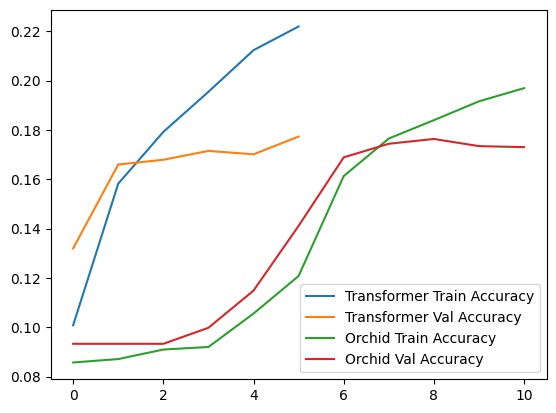

In [23]:
# Test the Model
def test(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        #for input_ids, labels, attention_mask in test_loader:
        for batch in tqdm(test_loader, desc=f"Test"):
            # Process each batch
            input_ids = batch[0].to(device, non_blocking=True)
            labels = batch[1].to(device, non_blocking=True)
            attention_mask = batch[2].to(device, non_blocking=True)
            logits = model(input_ids,attention_mask=attention_mask).logits
            predictions = logits.argmax(dim=-1)
            correct += (predictions == labels).sum().item()
            total += (labels != -100).sum().item()
    return correct / total

transformer_test_acc = test(transformer_model, test_loader)
orchid_test_acc = test(orchid_model, test_loader)

print(f"Transformer Test Accuracy: {transformer_test_acc:.4f}")
print(f"Orchid Test Accuracy: {orchid_test_acc:.4f}")

# Plot Training and Validation Accuracy
plt.plot(transformer_acc[0], label="Transformer Train Accuracy")
plt.plot(transformer_acc[1], label="Transformer Val Accuracy")
plt.plot(orchid_acc[0], label="Orchid Train Accuracy")
plt.plot(orchid_acc[1], label="Orchid Val Accuracy")
plt.legend()
plt.show()

conv_l_list = []
test_acc_list = []
for conv_l in range (5,51,2):
    model_test = OrchidBERT(config, seq_len, l_conv1d=conv_l).to(device)
    train_acc = train(model_test, train_loader, val_loader)
    test_acc = test(model_test, test_loader)
    
    print(f"conv_l {conv_l}, test acc: {test_acc}")
    conv_l_list.append(conv_l)
    test_acc_list.append(test_acc)
    
plt.plot(conv_l_list,test_acc_list)

In [24]:
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    print('model size: {:.3f}MB'.format(size_all_mb))
    return size_all_mb

In [25]:
get_model_size(transformer_model)

model size: 2.627MB


2.6270599365234375

In [26]:
get_model_size(orchid_model)

model size: 5.633MB


5.6334075927734375

In [ ]:
for batch in train_loader:
    labels = batch[1]
    print(labels.shape)
    break

In [ ]:
(labels == labels).sum().item()